# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_136  Q92932;Q92932-2;Q92932-3;Q92932-4   18.121
Sample_102  P05413;S4R371                       15.032
Sample_118  H3BRQ4;K4DIB9;P50238                12.619
Sample_146  A0A0A0MRZ8;P04433                   23.208
Sample_168  Q99538                              18.072
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                        
Sample_143  Q9GZP4;Q9GZP4-2                                          15.509
Sample_034  A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2   14.710
Sample_049  A0A0D9SF30                                               14.809
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.075
            A0A075B6Q5                 11.605
            A0A075B6R2                 13.259
            A0A075B6S5                 11.453
            A0A087WSY4                 11.705
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.644
            Q9UI40;Q9UI40-2            12.527
            Q9UIW2                     13.627
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.841
            Q9UP79                     12.548
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.755,15.050,16.842,19.863,15.625,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.707,19.067,...,15.528,15.576,14.217,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.609,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.509,17.705,17.039,16.390,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.786,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.526,15.345,17.084,18.708,14.249,19.433,12.682,11.009
Sample_207,15.739,16.877,15.469,16.898,15.289,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.601,12.340,13.310,12.860,12.600,12.922,12.675,13.337,12.060,12.589
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.352,19.067,16.127,...,12.694,13.157,12.567,13.610,13.193,12.838,12.624,13.550,12.669,12.801
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.836,12.516,11.715,13.837,12.552,13.648,13.232,13.558,11.387,13.301
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.788,13.280,12.955,12.411,12.235,13.334,12.739,12.290,12.611,12.360
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.008,12.473,12.779,12.348,11.786,12.855,13.130,12.344,12.668,12.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.316,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 165.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.59it/s]

100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.17it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.92it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.43it/s]

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.22it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.34it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.26it/s]

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.81it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.34it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.97it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.79it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.76it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.81it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.94it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.23it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.04it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.85it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.71it/s]

100%|██████████| 8/8 [00:01<00:00,  3.80it/s]

100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.95it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.44it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.71it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.99it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.78it/s]

100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.41it/s]

 30%|███       | 3/10 [00:00<00:01,  4.57it/s]

 40%|████      | 4/10 [00:00<00:01,  4.06it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.90it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.76it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.68it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.43it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.46it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.98it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.36it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.85it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.73it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.56it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.54it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.73it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.80it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.78it/s]

100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

100%|██████████| 11/11 [00:02<00:00,  3.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.95it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.41it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.39it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.02it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.96it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.86it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.84it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.58it/s]

100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

100%|██████████| 12/12 [00:03<00:00,  3.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.08it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.03it/s]

 31%|███       | 4/13 [00:00<00:02,  3.83it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.80it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.85it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.59it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.32it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.38it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.39it/s]

100%|██████████| 13/13 [00:03<00:00,  3.43it/s]

100%|██████████| 13/13 [00:03<00:00,  3.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.67it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.66it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.64it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.41it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.86it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.49it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.53it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.52it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.62it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.79it/s]

100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

100%|██████████| 14/14 [00:04<00:00,  2.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.30it/s]

 20%|██        | 3/15 [00:00<00:03,  3.71it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.60it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.53it/s]

 40%|████      | 6/15 [00:01<00:02,  3.48it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.38it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.61it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.77it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.75it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.69it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.63it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.38it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.91it/s]

100%|██████████| 15/15 [00:04<00:00,  2.89it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.041 0.011          0.562 0.453       0.075   
2             0.004 0.001      0.039 0.007          0.663 0.148       0.447   
3             0.003 0.000      0.038 0.006          0.806 0.087       0.723   
4             0.003 0.000      0.038 0.008          0.799 0.080       0.776   
5             0.004 0.000      0.038 0.003          0.803 0.089       0.767   
6             0.004 0.001      0.038 0.005          0.805 0.093       0.758   
7             0.004 0.000      0.037 0.000          0.816 0.082       0.830   
8             0.004 0.000      0.037 0.002          0.821 0.083       0.827   
9             0.004 0.001      0.038 0.004          0.819 0.081       0.821   
10            0.004 0.001      0.037 0.007          0.818 0.081       0.816   
11            0.004 0.001      0.039 0.006          0.832 0.078       0.814   
12            0.006 0.003      0.054 0.020          0.837 0.076       0.831   
13            0.005 0.002      0.045 0.013          0.821 0.086       0.832   
14            0.005 0.002      0.047 0.018          0.826 0.087       0.826   
15            0.005 0.002      0.050 0.020          0.826 0.087       0.826   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.127 0.125                  0.531 0.037        0.845   
2          0.111   0.522 0.098                  0.633 0.065        0.697   
3          0.091   0.757 0.064                  0.795 0.052        0.886   
4          0.097   0.782 0.064                  0.814 0.054        0.896   
5          0.095   0.780 0.068                  0.812 0.057        0.898   
6          0.105   0.775 0.074                  0.810 0.060        0.897   
7          0.102   0.819 0.075                  0.846 0.064        0.914   
8          0.104   0.820 0.076                  0.847 0.065        0.912   
9          0.100   0.816 0.071                  0.843 0.061        0.914   
10         0.102   0.813 0.072                  0.841 0.062        0.913   
11         0.090   0.819 0.064                  0.846 0.053        0.920   
12         0.093   0.830 0.065                  0.855 0.055        0.923   
13         0.105   0.823 0.078                  0.849 0.066        0.923   
14         0.104   0.822 0.076                  0.848 0.064        0.923   
15         0.101   0.822 0.077                  0.848 0.065        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.820 0.087        210.000 0.000  
2          0.079                  0.653 0.096        210.000 0.000  
3          0.050                  0.867 0.058        210.000 0.000  
4          0.049                  0.874 0.059        210.000 0.000  
5          0.051                  0.880 0.059        210.000 0.000  
6          0.052                  0.880 0.059        210.000 0.000  
7          0.046                  0.900 0.050        210.000 0.000  
8          0.047                  0.895 0.053        210.000 0.000  
9          0.047                  0.898 0.053        210.000 0.000  
10         0.047                  0.897 0.053        210.000 0.000  
11         0.045                  0.907 0.050        210.000 0.000  
12         0.045                  0.907 0.051        210.000 0.000  
13         0.046                  0.906 0.054        210.000 0.000  
14         0.047                  0.906 0.055        210.000 0.000  
15         0.046                  0.904 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 223.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.46it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.96it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.34it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.13it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.71it/s]

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.72it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.57it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.28it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.35it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.41it/s]

100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.02it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.55it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.30it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.32it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.45it/s]

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.50it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.51it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.38it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.94it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.62it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.29it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.16it/s]

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.43it/s]

 30%|███       | 3/10 [00:00<00:02,  3.49it/s]

 40%|████      | 4/10 [00:01<00:01,  3.29it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.27it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.56it/s]

100%|██████████| 10/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.46it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.30it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.03it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.04it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.10it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.07it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.06it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.81it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.56it/s]

100%|██████████| 11/11 [00:03<00:00,  2.39it/s]

100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.56it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.32it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.25it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.03it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.96it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.00it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.93it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.97it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.25it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.71it/s]

 31%|███       | 4/13 [00:01<00:03,  2.47it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.47it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.58it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.71it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.73it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.81it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.75it/s]

100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.10it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.14it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.43it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.22it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.25it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.44it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.41it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.27it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.38it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.71it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:05<00:00,  3.13it/s]

100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.04it/s]

 20%|██        | 3/15 [00:00<00:03,  3.82it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.41it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.15it/s]

 40%|████      | 6/15 [00:01<00:02,  3.11it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.89it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.96it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.90it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.93it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.95it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.67it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.63it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.55it/s]

100%|██████████| 15/15 [00:05<00:00,  2.46it/s]

100%|██████████| 15/15 [00:05<00:00,  2.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.003      0.062 0.028          0.000 0.000       0.000   
2             0.005 0.002      0.054 0.020          0.760 0.088       0.591   
3             0.005 0.002      0.049 0.017          0.783 0.085       0.694   
4             0.004 0.001      0.043 0.012          0.784 0.100       0.721   
5             0.004 0.002      0.041 0.010          0.783 0.100       0.719   
6             0.004 0.001      0.037 0.014          0.762 0.097       0.715   
7             0.004 0.001      0.042 0.012          0.792 0.087       0.760   
8             0.005 0.003      0.045 0.017          0.797 0.086       0.759   
9             0.005 0.002      0.048 0.018          0.783 0.088       0.787   
10            0.005 0.003      0.054 0.022          0.780 0.097       0.776   
11            0.005 0.002      0.050 0.019          0.848 0.083       0.800   
12            0.005 0.002      0.048 0.020          0.842 0.084       0.802   
13            0.006 0.002      0.064 0.019          0.866 0.078       0.824   
14            0.005 0.003      0.054 0.027          0.871 0.075       0.825   
15            0.005 0.003      0.047 0.016          0.862 0.085       0.819   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.862   
2          0.124   0.656 0.093                  0.726 0.059        0.796   
3          0.111   0.730 0.080                  0.775 0.060        0.873   
4          0.101   0.745 0.074                  0.784 0.061        0.875   
5          0.106   0.743 0.076                  0.783 0.061        0.873   
6          0.125   0.730 0.088                  0.773 0.069        0.872   
7          0.096   0.771 0.070                  0.805 0.059        0.899   
8          0.101   0.772 0.070                  0.807 0.057        0.896   
9          0.113   0.780 0.079                  0.812 0.066        0.895   
10         0.113   0.772 0.081                  0.806 0.068        0.908   
11         0.089   0.819 0.066                  0.846 0.055        0.930   
12         0.090   0.817 0.066                  0.844 0.055        0.928   
13         0.085   0.841 0.061                  0.864 0.050        0.934   
14         0.088   0.844 0.063                  0.867 0.052        0.934   
15         0.092   0.836 0.067                  0.859 0.056        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.830 0.087        210.000 0.000  
2          0.067                  0.758 0.085        210.000 0.000  
3          0.051                  0.841 0.069        210.000 0.000  
4          0.052                  0.834 0.074        210.000 0.000  
5          0.052                  0.831 0.075        210.000 0.000  
6          0.053                  0.832 0.074        210.000 0.000  
7          0.048                  0.874 0.061        210.000 0.000  
8          0.049                  0.872 0.062        210.000 0.000  
9          0.052                  0.871 0.065        210.000 0.000  
10         0.046                  0.886 0.058        210.000 0.000  
11         0.040                  0.916 0.049        210.000 0.000  
12         0.040                  0.914 0.048        210.000 0.000  
13         0.039                  0.921 0.046        210.000 0.000  
14         0.039                  0.922 0.046        210.000 0.000  
15         0.039                  0.923 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 999.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.91it/s]

100%|██████████| 3/3 [00:00<00:00, 21.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.27it/s]

100%|██████████| 4/4 [00:00<00:00, 18.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.19it/s]

100%|██████████| 5/5 [00:00<00:00, 18.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.20it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.59it/s]

100%|██████████| 6/6 [00:00<00:00, 11.64it/s]

100%|██████████| 6/6 [00:00<00:00, 12.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.35it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.24it/s]

100%|██████████| 7/7 [00:00<00:00, 16.40it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.04it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 14.54it/s]

100%|██████████| 8/8 [00:00<00:00, 14.06it/s]

100%|██████████| 8/8 [00:00<00:00, 14.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 14.82it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.35it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.97it/s]

100%|██████████| 9/9 [00:00<00:00, 10.39it/s]

100%|██████████| 9/9 [00:00<00:00, 10.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 15.66it/s]

 40%|████      | 4/10 [00:00<00:00, 12.24it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.05it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.28it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.39it/s]

100%|██████████| 10/10 [00:01<00:00,  8.57it/s]

100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 24.02it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.29it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.69it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.57it/s]

100%|██████████| 11/11 [00:00<00:00, 13.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.72it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.41it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.32it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.06it/s]

100%|██████████| 12/12 [00:00<00:00, 11.89it/s]

100%|██████████| 12/12 [00:00<00:00, 12.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.58it/s]

 38%|███▊      | 5/13 [00:00<00:00, 10.74it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.34it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.66it/s]

 85%|████████▍ | 11/13 [00:01<00:00, 10.25it/s]

100%|██████████| 13/13 [00:01<00:00, 10.03it/s]

100%|██████████| 13/13 [00:01<00:00, 10.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.16it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.42it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.15it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.92it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.49it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.32it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.44it/s]

100%|██████████| 14/14 [00:01<00:00, 10.28it/s]

100%|██████████| 14/14 [00:01<00:00,  9.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.56it/s]

 40%|████      | 6/15 [00:00<00:00, 13.04it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.17it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.47it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.91it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.89it/s]

100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.054 0.023          0.000 0.000       0.000   
2             0.004 0.003      0.045 0.017          0.624 0.122       0.402   
3             0.005 0.002      0.053 0.022          0.620 0.121       0.405   
4             0.004 0.001      0.041 0.011          0.620 0.118       0.407   
5             0.006 0.003      0.063 0.027          0.608 0.118       0.406   
6             0.006 0.003      0.066 0.030          0.611 0.115       0.400   
7             0.007 0.005      0.070 0.033          0.660 0.125       0.442   
8             0.005 0.002      0.057 0.023          0.656 0.118       0.449   
9             0.005 0.002      0.055 0.025          0.643 0.128       0.439   
10            0.004 0.002      0.046 0.020          0.639 0.110       0.499   
11            0.006 0.003      0.071 0.031          0.636 0.113       0.492   
12            0.006 0.003      0.059 0.021          0.626 0.100       0.530   
13            0.005 0.002      0.048 0.016          0.618 0.098       0.527   
14            0.005 0.002      0.049 0.019          0.647 0.094       0.586   
15            0.008 0.004      0.088 0.036          0.675 0.090       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.723   
2          0.101   0.481 0.097                  0.609 0.062        0.678   
3          0.100   0.482 0.094                  0.608 0.061        0.673   
4          0.107   0.482 0.092                  0.608 0.059        0.677   
5          0.098   0.477 0.084                  0.601 0.057        0.674   
6          0.098   0.473 0.081                  0.601 0.052        0.667   
7          0.102   0.520 0.091                  0.633 0.061        0.696   
8          0.100   0.525 0.090                  0.635 0.060        0.699   
9          0.114   0.513 0.106                  0.629 0.063        0.693   
10         0.096   0.553 0.083                  0.642 0.063        0.735   
11         0.100   0.547 0.087                  0.639 0.064        0.729   
12         0.119   0.567 0.097                  0.648 0.069        0.745   
13         0.120   0.562 0.098                  0.643 0.069        0.743   
14         0.107   0.610 0.089                  0.675 0.067        0.767   
15         0.119   0.644 0.093                  0.703 0.070        0.778   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.076                  0.676 0.090        210.000 0.000  
2          0.076                  0.631 0.086        210.000 0.000  
3          0.078                  0.626 0.085        210.000 0.000  
4          0.078                  0.625 0.089        210.000 0.000  
5          0.080                  0.627 0.090        210.000 0.000  
6          0.081                  0.622 0.091        210.000 0.000  
7          0.076                  0.651 0.088        210.000 0.000  
8          0.077                  0.644 0.093        210.000 0.000  
9          0.079                  0.642 0.092        210.000 0.000  
10         0.077                  0.690 0.085        210.000 0.000  
11         0.078                  0.685 0.087        210.000 0.000  
12         0.078                  0.702 0.090        210.000 0.000  
13         0.077                  0.699 0.088        210.000 0.000  
14         0.071                  0.716 0.087        210.000 0.000  
15         0.069                  0.714 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,13,15
score_time,12,13,15
test_precision,12,14,15
test_recall,13,14,15
test_f1,12,14,15
test_balanced_accuracy,12,14,15
test_roc_auc,14,14,15
test_average_precision,12,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.99it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.20it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.44it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.61it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.22it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.88it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.75it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.70it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.64it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.67it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.82it/s]

100%|██████████| 14/14 [00:06<00:00,  1.99it/s]

100%|██████████| 14/14 [00:06<00:00,  2.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.26it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.79it/s]

 40%|████      | 6/15 [00:00<00:00, 12.38it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.98it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.59it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.33it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.21it/s]

100%|██████████| 15/15 [00:01<00:00, 11.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.78it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.59it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.67it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.24it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.92it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.80it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.93it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.08it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.10it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.25it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.30it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.30it/s]

100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


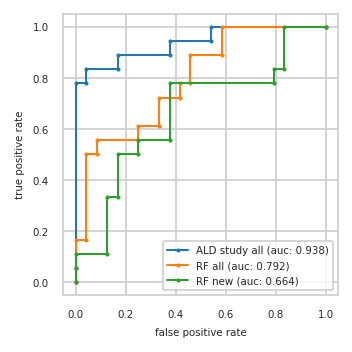

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.778  0.000 0.167  0.000 0.111
3          0.042 0.778  0.042 0.167  0.125 0.111
4          0.042 0.833  0.042 0.500  0.125 0.333
5          0.167 0.833  0.083 0.500  0.167 0.333
6          0.167 0.889  0.083 0.556  0.167 0.500
7          0.375 0.889  0.250 0.556  0.250 0.500
8          0.375 0.944  0.250 0.611  0.250 0.556
9          0.542 0.944  0.333 0.611  0.375 0.556
10         0.542 1.000  0.333 0.722  0.375 0.778
11         1.000 1.000  0.417 0.722  0.792 0.778
12           NaN   NaN  0.417 0.778  0.792 0.833
13           NaN   NaN  0.458 0.778  0.833 0.833
14           NaN   NaN  0.458 0.889  0.833 1.000
15           NaN   NaN  0.583 0.889  1.000 1.000
16           NaN   NaN  0.583 1.000    NaN   NaN
17           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,A0A0J9YXX1,Q9UI40;Q9UI40-2
2,P09486,Q9Y2T3;Q9Y2T3-3,E7EPV7;P37840;P37840-2
3,K7ERG9;P00746,P15151-2,J3KSJ8;Q9UD71;Q9UD71-2
4,P14174,P61981,P31321
5,P10636-2;P10636-6,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P61981,P04075,E5RK69;E7EMC6;P08133;P08133-2
7,Q6EMK4,P25189;P25189-2,Q9NUQ9
8,P14618,Q14894,H0Y7T8;P49418;P49418-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


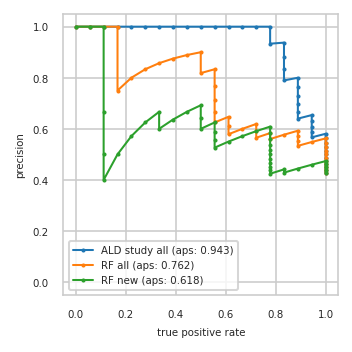

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.424 0.778
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.548 0.944     0.452 0.778
12         0.567 0.944     0.533 0.889     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.640 0.889     0.560 0.778     0.560 0.778
18         0.667 0.889     0.583 0.778     0.583 0.778
19         0.696 0.889     0.565 0.722     0.609 0.778
20         0.727 0.889     0.591 0.722     0.591 0.722
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.800 0.889     0.600 0.667     0.550 0.611
23         0.789 0.833     0.579 0.611     0.526 0.556
24         0.833 0.833     0.611 0.611     0.556 0.556
25         0.882 0.833     0.647 0.611     0.588 0.556
26         0.938 0.833     0.625 0.556     0.625 0.556
27         0.933 0.778     0.667 0.556     0.600 0.500
28         1.000 0.778     0.714 0.556     0.643 0.500
29         1.000 0.722     0.769 0.556     0.692 0.500
30         1.000 0.667     0.833 0.556     0.667 0.444
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


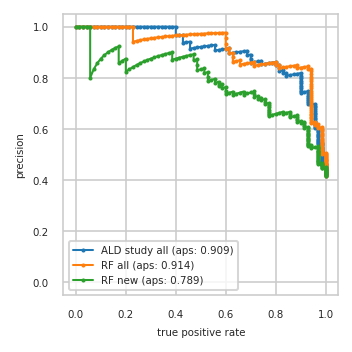

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


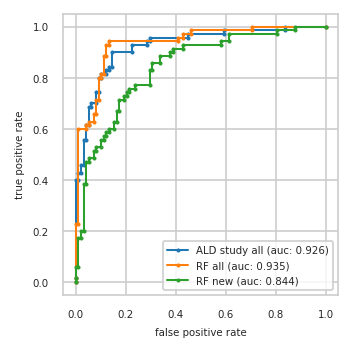

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}